In [2]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\thisi\appdata\local\temp\pip-req-build-atj2s7s2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36831 sha256=dace9107a3398feb3c141560a599270c2cf51bce3548fd6cfdbd49bdc2195e66
  Stored in directory: C:\Users\thisi\AppData\Local\Temp\pip-ephem-wheel-cache-uu86f8pt\wheels\15\d7\bd\05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment-anything


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\thisi\AppData\Local\Temp\pip-req-build-atj2s7s2'


In [3]:
!pip install torch torchvision opencv-python numpy

In [4]:
!nvidia-smi

Sat Jan 13 19:41:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  | 00000000:65:00.0  On |                  N/A |
|  0%   41C    P8              26W / 350W |    967MiB / 24576MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
# create sam predictor
import os
from segment_anything import SamPredictor, sam_model_registry


model_path = './sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)


--2024-01-13 20:08:52--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.5.75, 18.173.5.98, 18.173.5.63, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.5.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: 'sam_vit_b_01ec64.pth'

     0K .......... .......... .......... .......... ..........  0% 3,84M 93s
    50K .......... .......... .......... .......... ..........  0% 4,86M 83s
   100K .......... .......... .......... .......... ..........  0% 6,09M 75s
   150K .......... .......... .......... .......... ..........  0% 7,34M 68s
   200K .......... .......... .......... .......... ..........  0% 3,91M 73s
   250K .......... .......... .......... .......... ..........  0% 5,25M 72s
   300K .......... .......... .......... .......... ..........  0% 4,10M 74s
   350K .......... .......... .......... 

In [45]:
# coordi

def Capture_Event(event, x, y, flags, params):
    # If the left mouse button is pressed
    if event == cv2.EVENT_LBUTTONDOWN:
        # Print the coordinate of the 
        # clicked point
        print(f"({x}, {y})")
        
if __name__=="__main__":
    # Read the Image.
    img = cv2.imread("test.jpg", 1)
    # Show the Image
    cv2.imshow('image', img)
    # Set the Mouse Callback function, and call
    # the Capture_Event function.
    cv2.setMouseCallback('image', Capture_Event)
    # Press any key to exit
    cv2.waitKey(0)
    # Destroy all the windows
    cv2.destroyAllWindows()

(771, 663)


In [46]:
# load image and select x, y coordinates to test

import cv2
image_path = './test.jpg'
if not os.path.exists(image_path):
  !wget https://utils-computervisiondeveloper.s3.amazonaws.com/media/public/test.jpg

x = 771
y = 663

image = cv2.imread(image_path)

In [47]:

# use sam predictor on (image, x, y) to get location of subject
import numpy as np


predictor.set_image(image)

masks, scores, logits = predictor.predict(
                                  point_coords=np.asarray([[x, y]]),
                                  point_labels=np.asarray([1]),
                                  multimask_output=True
                              )

C, H, W = masks.shape

result_mask = np.zeros((H, W), dtype=bool)
count = 0
for j in range(C):
    
    count+=1
    result_mask |= masks[j, :, :]
print(count)
result_mask = result_mask.astype(np.uint8)

3


In [48]:
type(result_mask)

numpy.ndarray

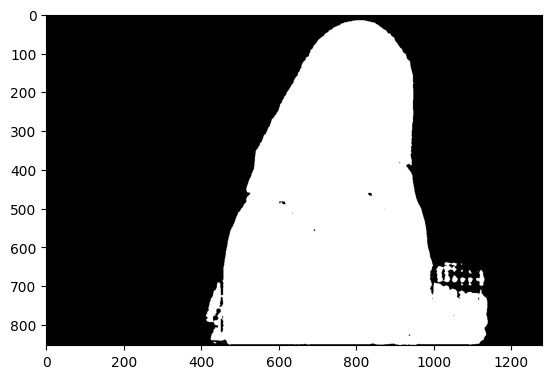

In [49]:
import matplotlib.pyplot as plt
plt.imshow(result_mask, cmap='gray')

In [50]:

# remove background
alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

alpha_channel[result_mask == 0] = 0

result_image = cv2.merge((image, alpha_channel))

In [1]:
#import matplotlib.pyplot as plt
#plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))

In [31]:
# wrap it up as a function
import base64
import os

from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np


model_path = './sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)


def remove_background(image_base64_encoding, x, y):

  image_bytes = base64.b64decode(image_base64_encoding)

  image = cv2.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

  predictor.set_image(image)

  masks, scores, logits = predictor.predict(
                                    point_coords=np.asarray([[x, y]]),
                                    point_labels=np.asarray([1]),
                                    multimask_output=True
                                )

  C, H, W = masks.shape

  result_mask = np.zeros((H, W), dtype=bool)

  for j in range(C):
    result_mask |= masks[j, :, :]

  result_mask = result_mask.astype(np.uint8)

  alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

  alpha_channel[result_mask == 0] = 0

  result_image = cv2.merge((image, alpha_channel))

  _, result_image_bytes = cv2.imencode('.png', result_image)

  result_image_bytes = result_image_bytes.tobytes()

  result_image_bytes_encoded_base64 = base64.b64encode(result_image_bytes).decode('utf-8')

  return result_image_bytes_encoded_base64